<a href="https://colab.research.google.com/github/mrinal-r/Experiments/blob/master/Word_Based_Text_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Import all modules to be used in the project

import string

from keras.preprocessing.text import Tokenizer

from numpy import array
import numpy as np
from keras.utils import to_categorical

from pickle import dump

from keras.preprocessing.sequence import pad_sequences

from pickle import load
from keras.models import load_model
from random import randint

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

from keras.utils import plot_model

from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

import matplotlib.pyplot as plt

from math import floor

from keras.callbacks import ModelCheckpoint

from google.colab import files

import keras



# Functions

This section contains functions used for data preprocessing, feature engineering, and utility functions

In [0]:
# Purpose: Load doc into memory
# Input: file name
# Output: text

def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


In [0]:
# Purpose: turn a doc into clean tokens
# Input: document
# Output: a list of tokens that are all in lowercase, have no special characters, split at white spaces

def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token ; string-to-replace, string-to-be-replaced-with, string-to-delete
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens



In [0]:
# Purpose: organize into sequences of tokens
# Input: document tokens, input sequence length
# Output: document broken down into sequences seperated by WS

def create_sequences(tokens, seq_length):
  print('Input sequence length is %d'% seq_length)
  # length = in_length + out_length
  total_length = seq_length+1
  #declare a variable to hold the sequences
  doc_sequences = list()
  for i in range(total_length, len(tokens)):
    # list of tokens; list size = total sequence length
    curr_line_seq = tokens[i-total_length:i]
    # create one string sequence seperated by WS
    curr_line = ' '.join(curr_line_seq)
    # append it to list of such sequences
    doc_sequences.append(curr_line)
  return doc_sequences



In [0]:
# Purpose: save a document
# Input: document , filename
# Output: none

def save_doc(doc, doc_filename):
	data = '\n'.join(doc)
	file = open(doc_filename, 'w')
	file.write(data)
	file.close()
  
 


In [0]:
# Purpose: load a file containing document as sequence
# Input: filename
# Output: document sequences

def load_sequenced_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	saved_doc_sequences = file.read()
	# close the file
	file.close()
	return saved_doc_sequences



In [0]:
# Purpose: convert sequences to integer vectors
# Input: list of sequences (text)
# Output: list of sequences (int) (list of lists) , vocabulary size
# Uses: save_tokenizer_artifacts

def text_to_int_tokenize(text_seq, tokenizer_name):
  # tokenize
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_seq)
  int_seq = tokenizer.texts_to_sequences(text_seq)

  # find the vocab size
  vocab_size = len(tokenizer.word_index) + 1
  save_tokenizer_artifacts(tokenizer, tokenizer_name)
  return int_seq, vocab_size



In [0]:
# Purpose: Create input and labels
# Input: tokenized document sequences (), size of vocabulary
# Output: inputs (), Labels ()

def create_inputs_and_labels(tokenized_doc_seq, vocab_size):
  # convert list to array
  array_tokenized_doc_seq = array(tokenized_doc_seq)
  inputs = array_tokenized_doc_seq[:,:-1]
  labels = array_tokenized_doc_seq[:,-1]
  # one hot encode labels; # columns = vocab size
  labels = to_categorical(labels, num_classes=vocab_size)
  return inputs,labels



In [0]:
# Purpose: Save tokenizer to file
# Input: tokenizer(model), name
# Output: file saved in your temp workspace

def save_tokenizer_artifacts(tokenizer, tokenizer_name):
  
  # save the tokenizer
  dump(tokenizer, open(tokenizer_name, 'wb'))
  
  files.download(tokenizer_name)
  


In [0]:
# Purpose: Save model to file
# Input: model, name
# Output: file saved in your temp workspace

def save_model_artifacts(model_name, model):
  # save the model to file
  model.save(model_name)
  
  files.download(model_name)
  
  

In [0]:
# Purpose: Generates the next n words in the sequence using trained model
# Input: model, tokenizer, seed text, length of sequence and # words to be predicted
# Output: concatenated predicted words

def generate_seq(model, tokenizer, input_seq_length, in_text, n_words):
	result = list()
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		in_text_encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		in_text_encoded = pad_sequences([in_text_encoded], maxlen=input_seq_length, truncating='pre')
		# predict probabilities for each word
		next_word_int = model.predict_classes(in_text_encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == next_word_int:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)



In [0]:
# Purpose: wrapper function for generate_seq
# Input: name of the file containing the test sequences, name of the model and the tokenizer
# Output: seed text and generated text
# Uses: generate_seq()

def predict_from_seed_data(in_filename, model_name, tokenizer_name):
  
  # load cleaned text sequences: list oflists
  text_sequence_doc = load_doc(in_filename)
  text_sequence_lines = text_sequence_doc.split('\n')
  
  # load the model
  my_model = load_model(model_name)
  
  # load the tokenizer
  my_tokenizer = load(open(tokenizer_name, 'rb'))
  
  seed_text = text_sequence_lines[randint(0,len(text_sequence_lines))]
  print(seed_text + '\n')
  
  input_seq_length = len(text_sequence_lines[0].split()) - 1
  generated_text = generate_seq(my_model, my_tokenizer, input_seq_length, seed_text, 50)
  
  return seed_text, generated_text



In [0]:
def plot_acc_loss(model):
  plt.plot(model.history['acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper left')
  plt.show()

  plt.plot(model.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train'], loc='upper left')
  plt.show()



# Models

# Model 1: Embedding - LSTM - Dense

This is one of the models used for benchmarking


In [0]:
# Dependencies on inputs: Vocabulary size(from tokenizer), input sequence length
# tweakable factors: Output dim of embedding layer that determines the compactness of the embedding vector

def Embed_LSTM_Dense(vocab_size, input_seq_length):
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size, 
                      output_dim = 50, 
                      input_length=input_seq_length))
  model.add(LSTM(100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(vocab_size, activation='softmax'))
  return model



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            42800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 856)               86456     
Total params: 280,156
Trainable params: 280,156
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2338/2338 [==============================] - 4s 2ms/step - loss: 6.6368 - acc: 0.0701
Epoch 2/100
2338/2338 [==========

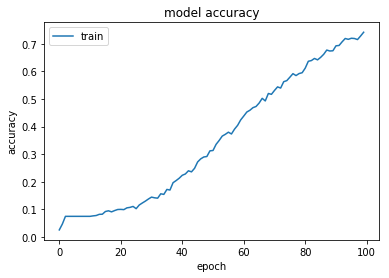

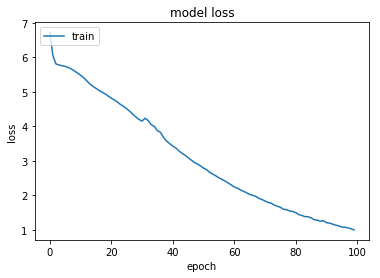

In [25]:
# run this after all the data is prepped
model_name = 'model_1_pob.h5'

# Create
Embed_LSTM_Dense_model = Embed_LSTM_Dense(sizeof_vocab, X_data.shape[1])

# print summary
print(Embed_LSTM_Dense_model.summary())

# compile model
Embed_LSTM_Dense_model.compile(loss='categorical_crossentropy', 
                               optimizer='adam', 
                               metrics=['accuracy'])

# adding a checkpoint| we monitor accuracy so the mode will be maximixed; for loss, its minimized
# we can leave it as auto but I'm explicitely mentioning as max
from keras.callbacks import ModelCheckpoint
model_savepoint = keras.callbacks.ModelCheckpoint(filepath= model_name, 
                                                  monitor='acc', 
                                                  verbose = 0 ,
                                                  save_best_only=True ,
                                                  save_weights_only=False, 
                                                  mode='max', 
                                                  period=1)

# fit model
Embed_LSTM_Dense_model_history = Embed_LSTM_Dense_model.fit(X_data, 
                                                            Y_data, 
                                                            callbacks = [model_savepoint],
                                                            batch_size=128, 
                                                            epochs=100) 

# plot
plot_acc_loss(Embed_LSTM_Dense_model_history)



# Model 2: Embedding - Convolutional - LSTM - Dense

Used for benchmarking.

In [0]:
# Dependencies on inputs: Vocabulary size(from tokenizer), input sequence length
# tweakable factors: Output dim of embedding layer that determines the compactness of the embedding vector, Drop out rate

def Embed_Conv_LSTM_Dense(vocab_size, input_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, 
                             output_dim = 100, 
                             input_length=input_seq_length))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(100))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    return model
  
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           85600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 856)               43656     
Total para

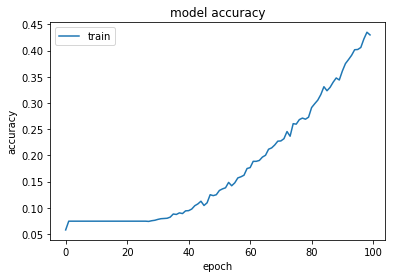

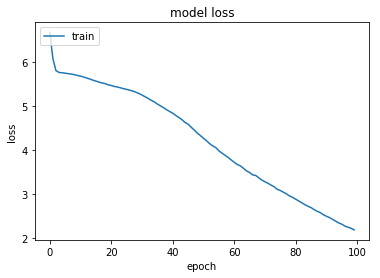

In [32]:
# run this after all the data is prepped
model_name = 'model_2_pob.h5'

# Create
Embed_Conv_LSTM_Dense_model = Embed_Conv_LSTM_Dense(sizeof_vocab, X_data.shape[1])

# print summary
print(Embed_Conv_LSTM_Dense_model.summary())

# compile model
Embed_Conv_LSTM_Dense_model.compile(loss='categorical_crossentropy', 
                                    optimizer='adam', 
                                    metrics=['accuracy'])

# adding a checkpoint| we monitor accuracy so the mode will be maximixed; for loss, its minimized
# we can leave it as auto but I'm explicitely mentioning as max
from keras.callbacks import ModelCheckpoint
model_savepoint = keras.callbacks.ModelCheckpoint(filepath= model_name, 
                                                  monitor='acc', 
                                                  verbose = 0 ,
                                                  save_best_only=True ,
                                                  save_weights_only=False, 
                                                  mode='max', 
                                                  period=1)

# fit model
Embed_Conv_LSTM_Dense_model_history = Embed_Conv_LSTM_Dense_model.fit(X_data, 
                                                                      Y_data, 
                                                                      callbacks = [model_savepoint],
                                                                      batch_size=128, 
                                                                      epochs=100) 

# plot
plot_acc_loss(Embed_Conv_LSTM_Dense_model_history)


# Model 3: Embedding - LSTM - Dense (My model)

Simple architecture that would help understand the behavior of the model. This model also gives me flexibility to change parameters and understand the relationship of parameters to output.

Simple 4 layer model with input sequence = 0.5 of output dimentionality of embedding layer and output dimentionality of embedding layer = # units of LSTM layer that follows.

Lets implement callbacks here since we know this model works well with the previous data set. So with a bigger text, we would like to save our model along the way so that we have something to work with of the session crashes.

In [0]:
# Dependencies on inputs: Vocabulary size(from tokenizer), input sequence length
# tweakable factors: None as of now since this model converges well and gives impressive results
# number at the end indicates number of layers
# Observations: # dims for embed layer = # LSTM units = # Dense units - kept on purpose
# might consider experimenting later to see if performance is affected

def Embed_LSTM_Dense_4(vocab_size, input_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, 
                    output_dim = 100, 
                    input_length = input_seq_length))
    # input: (samples = 2338, features = 50)
    # output: (timesteps = 2338, samples = 50, features = 100)
    # added dropout when it performed bad with validation data
    model.add(LSTM(units = 100, 
                   dropout = 0.5,
                   recurrent_dropout = 0.2,
                   activation = 'tanh', 
                   use_bias = 'False'))
    # output: (None, 100) 
    model.add(Dense(100, activation='relu'))
    # output: (None, 100) 
    # following layer should always have # units = dict size so that it matches the output
    model.add(Dense(vocab_size, activation='softmax'))
    # output: (None, 856) 
    # Shape of labels is: (2338, 856)
    return model
  
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           85600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 856)               86456     
Total params: 262,556
Trainable params: 262,556
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2338/2338 [==============================] - 2s 1ms/step - loss: 6.7308 - acc: 0.0252
Epoch 2/100
2338/2338 [==============================] - 2s 671us/step - loss: 6.0605 - acc: 0.0466
Epoch 3/100
2338/2338 [==============================] - 2s 687us

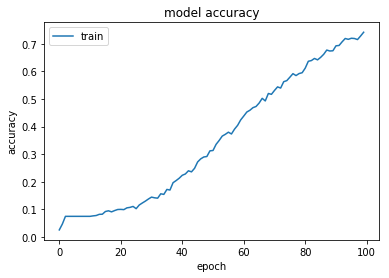

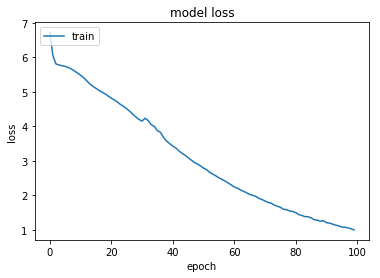

MessageError: ignored

In [19]:
# run this after all the data is prepped

model_name = 'model_3_pob.h5'

# Create
Embed_LSTM_Dense_4_model = Embed_LSTM_Dense_4(sizeof_vocab, X_data.shape[1])

# print summary
print(Embed_LSTM_Dense_4_model.summary())

# compile model
Embed_LSTM_Dense_4_model.compile(loss='categorical_crossentropy', 
                                 optimizer='adam', 
                                 metrics=['accuracy'])

# adding a checkpoint| we monitor accuracy so the mode will be maximixed; for loss, its minimized
# we can leave it as auto but I'm explicitely mentioning as max
from keras.callbacks import ModelCheckpoint
model_savepoint = keras.callbacks.ModelCheckpoint(filepath= model_name, 
                                                  monitor='acc', 
                                                  verbose = 0 ,
                                                  save_best_only=True ,
                                                  save_weights_only=False, 
                                                  mode='max', 
                                                  period=1)


# fit model
Embed_LSTM_Dense_4_model_history = Embed_LSTM_Dense_4_model.fit(x = X_data, 
                                                                y = Y_data, 
                                                                callbacks = [model_savepoint],
                                                                batch_size=128, 
                                                                epochs=100) 

# plot
plot_acc_loss(Embed_LSTM_Dense_4_model_history)

files.download(model_name)


# Data Preprocessing

In [17]:
# variables for filenames
text_name = 'APieceOfBread'

# load document
# Variable doc is just a string: <class 'str'>
in_filename = "/content/gdrive/My Drive/DL/" + text_name + '.txt'
doc = load_doc(in_filename)

# clean document
# Variable token is a list of strings(words): <class 'list'>
tokens = clean_doc(doc)
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

# create sequences from tokens
# doc_to_sequences is a list of sequences of 50 words: <class 'list'>
doc_to_sequences = list()
sequence_length = 50

# save sequences to file to be used later for prediction
doc_to_sequences = create_sequences(tokens,sequence_length)
print('Total Sequences: %d' % len(doc_to_sequences))

# doc_lines_seq is a list of sequences of 50 words: <class 'list'>, each elemnt within that list is a string
# print(type(doc_lines_seq)) : <class 'list'>
# print(type(doc_lines_seq[0])) : <class 'str'>
out_filename = text_name + '_sequences.txt'      # change this
save_doc(doc_to_sequences, out_filename)

# load saved text sequences. do this step if you already have the sequences created earlier
in_filename = text_name + '_sequences.txt'      # change this
doc_sequences = load_sequenced_doc(in_filename)
# load it into a list for processing. Splitting into elemennts by newline
doc_lines_seq = doc_sequences.split('\n')
print('Before tokenizing, sample length of input string sequence %d' % len(doc_lines_seq[0]))

# Vectorize the sequences using tokenizer. A word to int mapping dictionary will be created
# doc_lines_int_seq is a list of lists. Each sequence is a list
# print(type(doc_lines_int_seq)) : <class 'list'>
# print(type(doc_lines_int_seq[0])) : <class 'list'>
tokenizer_name = text_name + '_tokenizer.pkl'      # change this
doc_lines_int_seq, sizeof_vocab = text_to_int_tokenize(doc_lines_seq, tokenizer_name)

# create data
# X_data is 2D tensor (numpy array since data type is same) ; Y_data is 2D tensor
# X_data is <class 'numpy.ndarray'> with dimensions # samples, features = words in sequence
# Y_data is <class 'numpy.ndarray'> with dimension # samples, features = vocab size - sparse array
print('After tokenizing/vectorizing, sample length of input integers sequence %d' % len(doc_lines_int_seq[0]))
print('Size of the vocabulary build by the tokenizer %d' % sizeof_vocab)

X_data, Y_data = create_inputs_and_labels(doc_lines_int_seq, sizeof_vocab)

print("Shape of inputs is: {0}".format(X_data.shape))
print("Shape of labels is: {0}".format(Y_data.shape))

Total Tokens: 2389
Unique Tokens: 855
Input sequence length is 50
Total Sequences: 2338
Before tokenizing, sample length of input string sequence 281
After tokenizing/vectorizing, sample length of input integers sequence 51
Size of the vocabulary build by the tokenizer 856
Shape of inputs is: (2338, 50)
Shape of labels is: (2338, 856)


# Predicting the next word

In [36]:
# common testing seed

seed_text = doc_lines_seq[randint(0,len(doc_lines_seq))]
print(seed_text + '\n')
input_seq_length = len(doc_lines_seq[0].split()) - 1
print("Input length sequence is {}".format(input_seq_length))


at the ends which the children would take out of their baskets and throw on the sidewalks as they came from school i used to try to prowl around there when i went on errands at last my time was ended at this trade by which no man can support himself

Input length sequence is 50


In [43]:
tokenizer_name = 'APieceOfBread_tokenizer.pkl'
model1 = 'model_1_pob.h5'
model2 = 'model_2_pob.h5'
model3 = 'model_3_pob.h5'
predict_words = 50
my_tokenizer = load(open(tokenizer_name, 'rb'))

# Model 1
print("Testing Model 1")
# load the model 1
my_model1 = load_model(model1)
generated_text_1 = generate_seq(my_model1, my_tokenizer, input_seq_length, seed_text, predict_words)
print(generated_text_1 + '\n')

# Model 2
print("Testing Model 2")
my_model2 = load_model(model2)
generated_text_2 = generate_seq(my_model2, my_tokenizer, input_seq_length, seed_text, predict_words)
print(generated_text_2 + '\n')

# Model 3
print("Testing Model 3")
# load the model 1
my_model3 = load_model(model3)
generated_text_3 = generate_seq(my_model3, my_tokenizer, input_seq_length, seed_text, predict_words)
print(generated_text_3 + '\n')
  


Testing Model 1
hardimont are not hungry here is the soldier in his soldier at his few let fellow he gave he are just much his forehead it when you soil i have not not although the walking under hardimont crazy and when i was always not just it is is not never

Testing Model 2
did i not we to things i are you astonished me there i i it the duty with i he is he to he he you you you to to to to to not your me me i he he but to to to to to to to to me

Testing Model 3
well i do not laugh my friend it offends three years and duty tonight jeanvictor went on their frequent watches and alarms my forehead at the commissary officer all my ration of hunger the time i am just as well i have always remembered the soldier i am just out

